#### Data Dictionary 


Label -	        Whether the comment is sarcastic (1) or not sarcastic (0). Int

Comment -	    The actual comment from Reddit that is being analyzed. Object  

Author -	    Author of the comment. Object

Subreddit -	    The category on Reddit where the comment was written. Object

Score -	        The sum of Up-votes and Down-votes. This is a way for Reddit users to approve or disapprove of                 comments. Int

Ups -	        The amount of Up-votes (approving votes) a comment received. Int

Downs -	        The amount of Down-votes (dispproving votes) a comment received. Int

Date -	        The month and year the comment was created. Object 

Created utc -   The exact second the comment was created. Object 

Parent Comment-	The original comment or posting on Reddit that our analyzed comment replied to. Object         

The first Capstone notebook for my Sarcasm detection model and response generator.
First, let's import the libraries.

In [44]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import norm
import statsmodels.api as sm
from statsmodels.stats.proportion import proportions_ztest
import mpl_toolkits.mplot3d as m3d
from scipy import special

The data we will use is a sarcasm corpus dataset from Reddit. Let's import it.

In [45]:
df = pd.read_csv('/Users/lokikeeler/Downloads/train-balanced-sarcasm.csv')
df.head()
# https://www.kaggle.com/datasets/danofer/sarcasm?select=train-balanced-sarcasm.csv

,label,comment,author,subreddit,score,ups,downs,date,created_utc,parent_comment
0,0,NC and NH.,Trumpbart,politics,2,-1,-1,2016-10,2016-10-16 23:55:23,"Yeah, I get that argument. At this point, I'd ..."
1,0,You do know west teams play against west teams...,Shbshb906,nba,-4,-1,-1,2016-11,2016-11-01 00:24:10,The blazers and Mavericks (The wests 5 and 6 s...
2,0,"They were underdogs earlier today, but since G...",Creepeth,nfl,3,3,0,2016-09,2016-09-22 21:45:37,They're favored to win.
3,0,"This meme isn't funny none of the ""new york ni...",icebrotha,BlackPeopleTwitter,-8,-1,-1,2016-10,2016-10-18 21:03:47,deadass don't kill my buzz
4,0,I could use one of those tools.,cush2push,MaddenUltimateTeam,6,-1,-1,2016-12,2016-12-30 17:00:13,Yep can confirm I saw the tool they use for th...


It's important to note that the column 'label' is the indicator whether a comment is sarcastic or not (1 being sarcastic, 0 being not sarcastic). Also, the column 'score' is the sum of up and down votes.

Now let's perform multiple preliminary EDA of our data

In [48]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1010826 entries, 0 to 1010825
Data columns (total 10 columns):
 #   Column          Non-Null Count    Dtype 
---  ------          --------------    ----- 
 0   label           1010826 non-null  int64 
 1   comment         1010771 non-null  object
 2   author          1010826 non-null  object
 3   subreddit       1010826 non-null  object
 4   score           1010826 non-null  int64 
 5   ups             1010826 non-null  int64 
 6   downs           1010826 non-null  int64 
 7   date            1010826 non-null  object
 8   created_utc     1010826 non-null  object
 9   parent_comment  1010826 non-null  object
dtypes: int64(4), object(6)
memory usage: 77.1+ MB


Now we can see which columns are integers and which are objects. Also we can see that we have just a few null values (comment column). Let's change the date columns to datetime, and get rid of the rows with null values

In [49]:
df['date'] = pd.to_datetime(df['date'])
df['created_utc'] = pd.to_datetime(df['created_utc'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1010826 entries, 0 to 1010825
Data columns (total 10 columns):
 #   Column          Non-Null Count    Dtype         
---  ------          --------------    -----         
 0   label           1010826 non-null  int64         
 1   comment         1010771 non-null  object        
 2   author          1010826 non-null  object        
 3   subreddit       1010826 non-null  object        
 4   score           1010826 non-null  int64         
 5   ups             1010826 non-null  int64         
 6   downs           1010826 non-null  int64         
 7   date            1010826 non-null  datetime64[ns]
 8   created_utc     1010826 non-null  datetime64[ns]
 9   parent_comment  1010826 non-null  object        
dtypes: datetime64[ns](2), int64(4), object(4)
memory usage: 77.1+ MB


Dates are done, now let's do the nulls

In [50]:
df = df.dropna()
df.isnull().sum()

label             0
comment           0
author            0
subreddit         0
score             0
ups               0
downs             0
date              0
created_utc       0
parent_comment    0
dtype: int64

Let's see how distributed the sarcasm is between our dataset

In [51]:
df['label'].value_counts()

label
0    505403
1    505368
Name: count, dtype: int64

Here we can see our dataset is very even between sarcastic and non sarcastic comments. This is good to note as we play with our dataset. Now let's take a look at some of these columns. Let's choose Author to start.

In [52]:
df['author'].value_counts()

author
Biffingston        845
pokemon_fetish     432
NeonDisease        422
ShyBiDude89        404
ivsciguy           342
                  ... 
seoul2002            1
YUNGA5TRO            1
mountaingoatery      1
SonaMechanics        1
lastnotice           1
Name: count, Length: 256560, dtype: int64

Here we can see there are over 25,000 rows of authors, yet not even one author has a count of 1000. Since this column is also an object data frame, let's drop this column as it will not be a good predictor of sarcasm and will clutter our data.

In [53]:
df = df.drop(columns=['author'])
df.head()

,label,comment,subreddit,score,ups,downs,date,created_utc,parent_comment
0,0,NC and NH.,politics,2,-1,-1,2016-10-01,2016-10-16 23:55:23,"Yeah, I get that argument. At this point, I'd ..."
1,0,You do know west teams play against west teams...,nba,-4,-1,-1,2016-11-01,2016-11-01 00:24:10,The blazers and Mavericks (The wests 5 and 6 s...
2,0,"They were underdogs earlier today, but since G...",nfl,3,3,0,2016-09-01,2016-09-22 21:45:37,They're favored to win.
3,0,"This meme isn't funny none of the ""new york ni...",BlackPeopleTwitter,-8,-1,-1,2016-10-01,2016-10-18 21:03:47,deadass don't kill my buzz
4,0,I could use one of those tools.,MaddenUltimateTeam,6,-1,-1,2016-12-01,2016-12-30 17:00:13,Yep can confirm I saw the tool they use for th...


Author has been dropped. Now let's look at our data on a year by year basis.

In [54]:
df['year'] = df['date'].dt.year
df['year'].value_counts()

year
2016    475686
2015    286856
2014    137512
2013     63558
2012     27307
2011     12723
2010      5279
2009      1850
Name: count, dtype: int64

In [55]:
df.groupby('year')['label'].sum().reset_index(name='label')

,year,label
0,2009,1078
1,2010,2977
2,2011,6944
3,2012,14592
4,2013,34193
5,2014,73506
6,2015,149297
7,2016,222781


In both of these entries we can see that there are the least amount of comments taken from the year 2009, and it increases every year until it ends in 2016. Also, we can see that there are more sarcastic comments each year because of this.

Let's continue by looking at some values of our data

In [56]:
df.describe().round(2)

,label,score,ups,downs,date,created_utc,year
count,1010771.0,1010771.00,1010771.00,1010771.00,1010771,1010771,1010771.00
mean,0.5,6.89,5.50,-0.15,2015-07-20 04:43:36.877612032,2015-08-04 10:52:45.726407424,2015.04
min,0.0,-507.00,-507.00,-1.00,2009-01-01 00:00:00,2009-01-01 23:08:43,2009.00
25%,0.0,1.00,0.00,0.00,2015-01-01 00:00:00,2015-01-08 16:44:59,2015.00
50%,0.0,2.00,1.00,0.00,2015-11-01 00:00:00,2015-11-30 20:32:24,2015.00
75%,1.0,4.00,3.00,0.00,2016-07-01 00:00:00,2016-07-15 13:18:38.500000,2016.00
max,1.0,9070.00,5163.00,0.00,2016-12-01 00:00:00,2016-12-31 23:58:26,2016.00
std,0.5,48.34,41.27,0.35,NaN,NaN,1.22


Immediately what stands out is that score has a 75% value of 4, yet a max of 9070. Likewise, Ups has a 75% value of 3, yet has a max of 5163. Let's dig deeper into score

In [57]:
df['score'].value_counts()

score
1       339997
2       162669
3        90285
0        58141
4        41978
         ...  
1803         1
1299         1
2104         1
1709         1
1015         1
Name: count, Length: 1291, dtype: int64

Let's see if we can see how much of our data is between a score of -200 and 200

<Axes: >

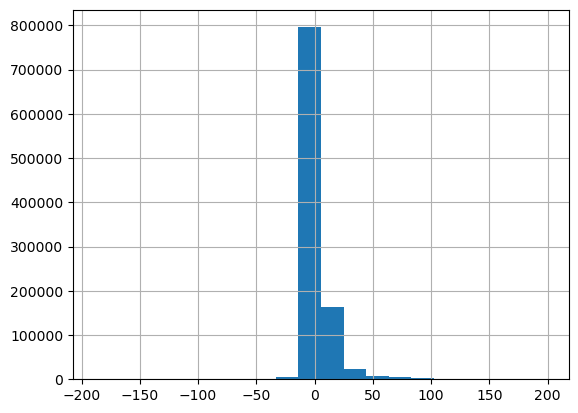

In [58]:
df[(df['score'] > -200) & (df['score']<200)]['score'].hist(bins=20)


We're starting to see a more normal distribution. Let's narrow it down between -20 and 20

<Axes: >

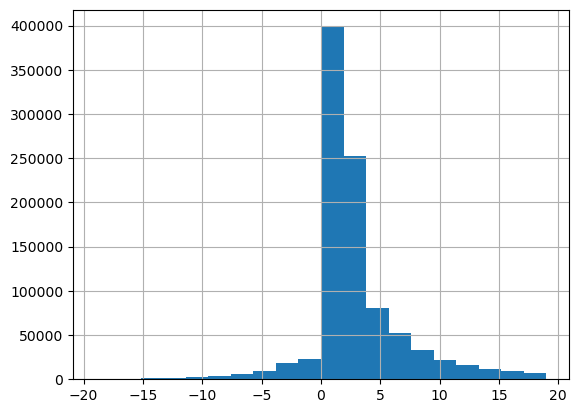

In [59]:
df[(df['score'] > -20) & (df['score']<20)]['score'].hist(bins=20)

Now we are getting a normal distribution for our data! Let's see how many datapoints are between these score values

In [60]:
len(df[(df['score'] > -20) & (df['score']<20)])/len(df)

0.9388753733536083

Nearly 94%! Interesting! Working with this part of our data gives us a normal distribution and reduces data points. Let's dive deeper into it

In [61]:
df_2 = df[(df['score'] > -20) & (df['score']<20)]

In [62]:
df_2.describe().round(2)

,label,score,ups,downs,date,created_utc,year
count,948988.0,948988.00,948988.00,948988.00,948988,948988,948988.00
mean,0.5,2.68,2.11,-0.14,2015-07-17 04:00:20.060107008,2015-08-01 09:58:15.330801920,2015.03
min,0.0,-19.00,-19.00,-1.00,2009-01-01 00:00:00,2009-01-01 23:08:43,2009.00
25%,0.0,1.00,0.00,0.00,2015-01-01 00:00:00,2015-01-05 12:01:23.249999872,2015.00
50%,0.0,2.00,1.00,0.00,2015-11-01 00:00:00,2015-11-28 06:42:48,2015.00
75%,1.0,3.00,3.00,0.00,2016-07-01 00:00:00,2016-07-13 23:26:03.750000128,2016.00
max,1.0,19.00,19.00,0.00,2016-12-01 00:00:00,2016-12-31 23:58:26,2016.00
std,0.5,4.03,3.94,0.35,NaN,NaN,1.23


These are much more reasonable values

Now our new dataframe has more values within a reasonable frame. This did seem to remove nearly half of our data which is a bit worrisome, though. Let's check how our label value counts look now

In [63]:
df_2['label'].value_counts()

label
0    475876
1    473112
Name: count, dtype: int64

Now our dataframe has a bit larger percent of non sarcastic comments rather than sarcastic, but still seems to be reasonably near to each other

Let's recheck our year over year change with our new dataframe and this time plot it

In [64]:
df_2['year'] = df_2['date'].dt.year
label_per_year = df_2.groupby(['year', 'label']).size().reset_index(name='count')
label_per_year

/var/folders/p3/9brtldpx18s3wvmp6_8sq07r0000gn/T/ipykernel_49899/4278385926.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_2['year'] = df_2['date'].dt.year


,year,label,count
0,2009,0,734
1,2009,1,1068
2,2010,0,2226
3,2010,1,2906
4,2011,0,5570
5,2011,1,6752
6,2012,0,12082
7,2012,1,13932
8,2013,0,27768
9,2013,1,32303


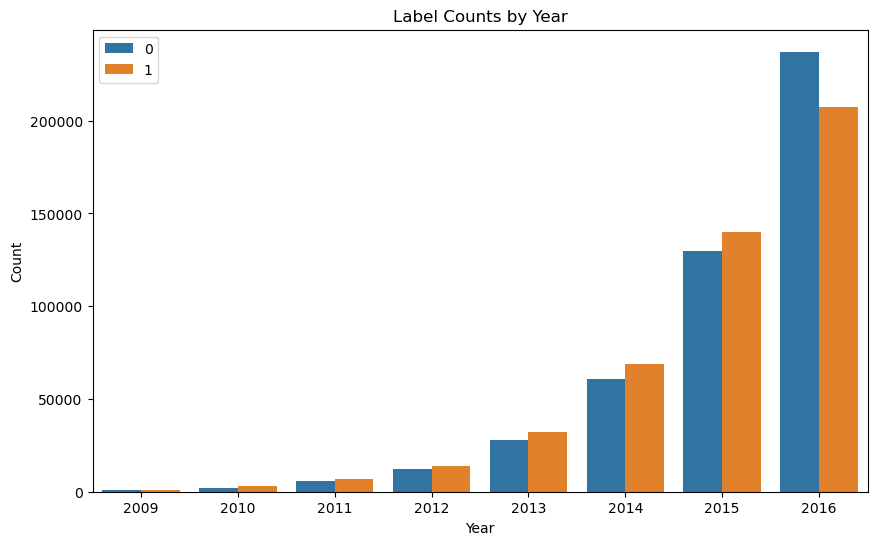

In [65]:
plt.figure(figsize=(10, 6))
sns.barplot(x='year', y='count', hue='label', data=label_per_year)
plt.xlabel('Year')
plt.ylabel('Count')
plt.title('Label Counts by Year')
plt.legend()
plt.show()

Here we can see a similar trend as before: There are a total number of comments each year, and also there are more sarcastic comments after every year. 

Why don't we look further into comments. How about how many comments consist only of numeric values? Let's use regex to do this

In [66]:
numeric_comments_mask = df_2['comment'].str.match(r'^\d+$')
numeric_comments_count = numeric_comments_mask.sum()
numeric_comments_count

522

This is a low number of comments. Let's see how many are sarcastic

In [67]:
numeric_comments_mask = df_2['comment'].str.match(r'^\d+$')
numeric_comments_count_by_label = df_2.groupby('label')['comment'].apply(lambda x: (x.str.match(r'^\d+$')).sum()).reset_index(name='numeric_comments_count')

# Display the result
print(numeric_comments_count_by_label)

   label  numeric_comments_count
0      0                     481
1      1                      41


Some are sarcastic while most are not. Interesting that just numeric answers can be sarcastic. Let's leave this in the dataset so our model has a better idea on how to deal with these answers

Next let's look at how many up votes are associated with sarcastic and non sarcastic comments

In [68]:
df_2.groupby('label')['ups'].sum().reset_index()

,label,ups
0,0,974638
1,1,1025122


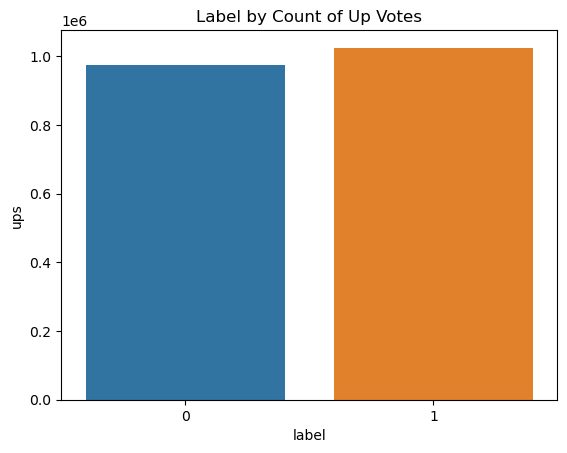

In [73]:
label_by_ups = df_2.groupby('label')['ups'].sum().reset_index()

sns.barplot(x='label', y='ups', data=label_by_ups)
plt.xlabel('label')
plt.ylabel('ups')
plt.title('Label by Count of Up Votes')
plt.show()

This shows that  sarcastic comments have more slightly more upvotes

Now let's look at the down votes

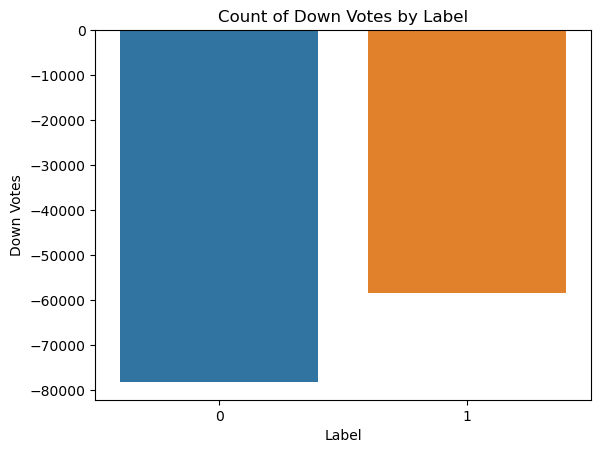

In [74]:
label_by_downs = df_2.groupby('label')['downs'].sum().reset_index()

sns.barplot(x='label', y='downs', data=label_by_downs)
plt.xlabel('Label')
plt.ylabel('Down Votes')
plt.title("Count of Down Votes by Label")
plt.show()

Non sarcastic comments seem to have much more down votes. This could be an indicator that upvotes are related to sarcasm. Let's remember this when we do our modeling

There's a chance that the subreddit has a strong correlation with whether the comment is sarcastic or not. Let's look into it.

In [71]:
df_2['subreddit'].value_counts()

subreddit
AskReddit          62463
politics           37314
worldnews          24811
leagueoflegends    19856
pcmasterrace       17789
                   ...  
manganews              1
TheGreatWar            1
golfwithfriends        1
FrugalTO               1
Pandemic               1
Name: count, Length: 14834, dtype: int64

In [75]:
df_2['subreddit'].value_counts().head(100)

subreddit
AskReddit           62463
politics            37314
worldnews           24811
leagueoflegends     19856
pcmasterrace        17789
                    ...  
TwoXChromosomes      1437
ukpolitics           1420
Futurology           1417
NoMansSkyTheGame     1414
Eve                  1408
Name: count, Length: 100, dtype: int64

There are many subreddits. Perhaps if we play with the top 100 subreddits we can dive deeper into our analysis

In [76]:
top_values = df_2['subreddit'].value_counts().head(100)
# Create a mask to filter the original dataframe based on the top values
mask = df_2['subreddit'].isin(top_values.index)
# Create a new dataframe with all columns but only rows where the 'column_name' is in the top 100
df_new = df_2[mask]

df_new['subreddit'].value_counts()

subreddit
AskReddit           62463
politics            37314
worldnews           24811
leagueoflegends     19856
pcmasterrace        17789
                    ...  
TwoXChromosomes      1437
ukpolitics           1420
Futurology           1417
NoMansSkyTheGame     1414
Eve                  1408
Name: count, Length: 100, dtype: int64

We have successfully reduced the subreddits to the top 100 instances. Now let's create dummy variables for these

In [78]:
dummy_variables = pd.get_dummies(df_new['subreddit'], prefix='SUB')
df_new_2 = pd.concat([df_new, dummy_variables], axis=1)

df_new_2.head()

,label,comment,subreddit,score,ups,downs,date,created_utc,parent_comment,year,...,SUB_television,SUB_tf2,SUB_todayilearned,SUB_trees,SUB_ukpolitics,SUB_unitedkingdom,SUB_videos,SUB_worldnews,SUB_wow,SUB_xboxone
0,0,NC and NH.,politics,2,-1,-1,2016-10-01,2016-10-16 23:55:23,"Yeah, I get that argument. At this point, I'd ...",2016,...,False,False,False,False,False,False,False,False,False,False
1,0,You do know west teams play against west teams...,nba,-4,-1,-1,2016-11-01,2016-11-01 00:24:10,The blazers and Mavericks (The wests 5 and 6 s...,2016,...,False,False,False,False,False,False,False,False,False,False
2,0,"They were underdogs earlier today, but since G...",nfl,3,3,0,2016-09-01,2016-09-22 21:45:37,They're favored to win.,2016,...,False,False,False,False,False,False,False,False,False,False
3,0,"This meme isn't funny none of the ""new york ni...",BlackPeopleTwitter,-8,-1,-1,2016-10-01,2016-10-18 21:03:47,deadass don't kill my buzz,2016,...,False,False,False,False,False,False,False,False,False,False
5,0,"I don't pay attention to her, but as long as s...",AskReddit,0,0,0,2016-09-01,2016-09-02 10:35:08,do you find ariana grande sexy ?,2016,...,False,False,False,False,False,False,False,False,False,False


Perfect! Now we can drop the original subreddit column

In [79]:
df_new_2 = df_new_2.drop(columns=['subreddit'])
df_new_2.head()

,label,comment,score,ups,downs,date,created_utc,parent_comment,year,SUB_2007scape,...,SUB_television,SUB_tf2,SUB_todayilearned,SUB_trees,SUB_ukpolitics,SUB_unitedkingdom,SUB_videos,SUB_worldnews,SUB_wow,SUB_xboxone
0,0,NC and NH.,2,-1,-1,2016-10-01,2016-10-16 23:55:23,"Yeah, I get that argument. At this point, I'd ...",2016,False,...,False,False,False,False,False,False,False,False,False,False
1,0,You do know west teams play against west teams...,-4,-1,-1,2016-11-01,2016-11-01 00:24:10,The blazers and Mavericks (The wests 5 and 6 s...,2016,False,...,False,False,False,False,False,False,False,False,False,False
2,0,"They were underdogs earlier today, but since G...",3,3,0,2016-09-01,2016-09-22 21:45:37,They're favored to win.,2016,False,...,False,False,False,False,False,False,False,False,False,False
3,0,"This meme isn't funny none of the ""new york ni...",-8,-1,-1,2016-10-01,2016-10-18 21:03:47,deadass don't kill my buzz,2016,False,...,False,False,False,False,False,False,False,False,False,False
5,0,"I don't pay attention to her, but as long as s...",0,0,0,2016-09-01,2016-09-02 10:35:08,do you find ariana grande sexy ?,2016,False,...,False,False,False,False,False,False,False,False,False,False


Let's create a new csv based on everything we will do so far

In [80]:
#df_new_2.to_csv('train-balanced-sarcasm_2.csv', index=False)